# Maestria en Ciencia de los Datos y Analitica

## Proyecto Final Almacenamiento y Recuperación de Información

## Integrantes:

### Diana Catalina Velasquez Gaviria
### Juan Camilo Cebellos Arias
### Juan Sevastian Moreno Zapata
### Julian Castelblanco Benitez
### Santiago Aristizabal Toro

## Tokenizacion y recuperación de información

In [1]:
import metapy
import pandas as pd
import wget

## Lectura de noticias

In [2]:
data = pd.read_csv('news.csv', sep=',')
data.head()
data.shape


(142570, 10)

In [3]:
print(len(data))
print(data['publication'].describe())

142570
count        142570
unique           15
top       Breitbart
freq          23781
Name: publication, dtype: object


In [4]:
print(data['title'].describe())

count     142568
unique    142132
top             
freq          12
Name: title, dtype: object


In [5]:
print(data['author'].describe())

count             126694
unique             15647
top       Breitbart News
freq                1559
Name: author, dtype: object


## Selección de las columnas objetivo

In [6]:
df = pd.DataFrame(data, columns = ['title', 'author','content'])
df.head()

,title,author,content
0,House Republicans Fret About Winning Their Hea...,Carl Hulse,WASHINGTON — Congressional Republicans have...
1,Rift Between Officers and Residents as Killing...,Benjamin Mueller and Al Baker,"After the bullet shells get counted, the blood..."
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",Margalit Fox,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",William McDonald,"Death may be the great equalizer, but it isn’t..."
4,Kim Jong-un Says North Korea Is Preparing to T...,Choe Sang-Hun,"SEOUL, South Korea — North Korea’s leader, ..."


### Concatenación de las columnas seleccionadas

In [7]:
ndata = pd.DataFrame(df['title'] + ' ' + df['author'] + ' ' + df['content'], columns=['documents'])
ndata.head()

,documents
0,House Republicans Fret About Winning Their Hea...
1,Rift Between Officers and Residents as Killing...
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi..."
4,Kim Jong-un Says North Korea Is Preparing to T...


In [8]:
ndata.to_csv('./data/documents/documents.dat', header=None, index=None)

In [9]:
idx=metapy.index.make_inverted_index('./Config/config.toml')

In [10]:
idx.num_docs()

142790

# Terminos unicos


In [11]:
idx.unique_terms()

314390

In [12]:
idx.avg_doc_length()

409.7702941894531

In [13]:
idx.total_corpus_terms()

58511099

In [14]:
ranker = metapy.index.OkapiBM25()

## Ejecución de la Consulta (Query)

In [15]:
query = metapy.index.Document()
query.content('Carl Hulse') 

In [16]:
top_docs = ranker.score(idx, query, num_results=5)
top_docs

[(139230, 15.726676940917969),
 (776, 14.231730461120605),
 (136488, 13.775187492370605),
 (49858, 13.736804962158203),
 (2971, 12.481700897216797)]

## Resultado de la Consulta

In [17]:
for num, (d_id, _) in enumerate(top_docs):
    content = idx.metadata(d_id).get('content')
    print("{}.{}...\n".format(num + 1, content[0:250]))

1."Surprised by Luke Russert’s departure from NBC? Here’s what Chuck Todd said a couple weeks ago. Callum Borchers      In a surprise move, NBC News Capitol Hill correspondent Luke Russert said Wednesday he is leaving the network in the middle of an el...

2."‘The Daily’: Making Sense of the Gorsuch Pick - The New York Times Michael Barbaro On the eve of our debut episode of “The Daily,” President Trump delivered a major news story. For his first Supreme Court nomination, he selected Neil M. Gorsuch, a c...

3."The 5 ways Senate Republicans are talking about the Supreme Court vacancy Amber Phillips        As the Senate returns to work Monday for the first time since Supreme Court Justice Antonin Scalia’s death, Senate Republicans have a major decision on t...

4."The Atlantic  Politics & Policy Daily: Congress Clocks In Candice Norwood         This article is part of a feature we also send out via email as Politics  Policy Daily, a daily roundup of events and ideas in American politics

## Inicialización Topic Detection

In [1]:
from pyspark.sql.types import *
from pyspark.sql.functions import monotonically_increasing_id, col, expr, when, concat, lit, isnan
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import pyspark

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local', "app-topic-detection") 
spark = SparkSession(sc)


## Lectura de las noticias

In [3]:
df=spark.read.csv("./Trabajo_Meta/news.csv", inferSchema=True, header= True)
df.show(10)

+---+-------+--------------------+--------------+--------------------+----------+------+-----+----+--------------------+
| id|id_news|               title|   publication|              author|      date|  year|month| url|             content|
+---+-------+--------------------+--------------+--------------------+----------+------+-----+----+--------------------+
|  0|  17283|House Republicans...|New York Times|          Carl Hulse|2016-12-31|2016.0| 12.0|null|WASHINGTON  —   C...|
|  1|  17284|Rift Between Offi...|New York Times|Benjamin Mueller ...|2017-06-19|2017.0|  6.0|null|After the bullet ...|
|  2|  17285|Tyrus Wong, ‘Bamb...|New York Times|        Margalit Fox|2017-01-06|2017.0|  1.0|null|When Walt Disney’...|
|  3|  17286|Among Deaths in 2...|New York Times|    William McDonald|2017-04-10|2017.0|  4.0|null|Death may be the ...|
|  4|  17287|Kim Jong-un Says ...|New York Times|       Choe Sang-Hun|2017-01-02|2017.0|  1.0|null|SEOUL, South Kore...|
|  5|  17288|Sick With a Cold,..

In [4]:
df.createOrReplaceTempView("train_df")
sqlDF = spark.sql("SELECT id_news,title,content FROM train_df")
sqlDF.show()

+-------+--------------------+--------------------+
|id_news|               title|             content|
+-------+--------------------+--------------------+
|  17283|House Republicans...|WASHINGTON  —   C...|
|  17284|Rift Between Offi...|After the bullet ...|
|  17285|Tyrus Wong, ‘Bamb...|When Walt Disney’...|
|  17286|Among Deaths in 2...|Death may be the ...|
|  17287|Kim Jong-un Says ...|SEOUL, South Kore...|
|  17288|Sick With a Cold,...|LONDON  —   Queen...|
|  17289|Taiwan’s Presiden...|BEIJING  —   Pres...|
|  17290|After ‘The Bigges...|Danny Cahill stoo...|
|  17291|First, a Mixtape....|Just how   is Hil...|
|  17292|Calling on Angels...|Angels are everyw...|
|  17293|Weak Federal Powe...|With Donald J. Tr...|
|  17294|Can Carbon Captur...|THOMPSONS, Tex.  ...|
|  17295|Mar-a-Lago, the F...|WEST PALM BEACH, ...|
|  17296|How to form healt...|This article is p...|
|  17297|Turning Your Vaca...|It’s the season f...|
|  17298|As Second Avenue ...|Finally. The Seco...|
|  17300|Dyl

In [5]:
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import matplotlib.pyplot as plt

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# stopwords en nltk
from nltk.corpus import stopwords
 
stop_words_nltk = set(stopwords.words('english'))

In [8]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA, BisectingKMeans
from pyspark.sql.functions import monotonically_increasing_id
import re

In [9]:
rawdata = sqlDF
rawdata.printSchema()
rawdata[0]
rawdata = rawdata.fillna({'content': ''})                               # Replace nulls with blank string

# Add Unique ID
rawdata = rawdata.withColumn("uid", monotonically_increasing_id())     # Create Unique ID

# Show rawdata (as DataFrame)
rawdata.show(10)

# Print data types
for type in rawdata.dtypes:
    print(type)


root
 |-- id_news: string (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)

+-------+--------------------+--------------------+---+
|id_news|               title|             content|uid|
+-------+--------------------+--------------------+---+
|  17283|House Republicans...|WASHINGTON  —   C...|  0|
|  17284|Rift Between Offi...|After the bullet ...|  1|
|  17285|Tyrus Wong, ‘Bamb...|When Walt Disney’...|  2|
|  17286|Among Deaths in 2...|Death may be the ...|  3|
|  17287|Kim Jong-un Says ...|SEOUL, South Kore...|  4|
|  17288|Sick With a Cold,...|LONDON  —   Queen...|  5|
|  17289|Taiwan’s Presiden...|BEIJING  —   Pres...|  6|
|  17290|After ‘The Bigges...|Danny Cahill stoo...|  7|
|  17291|First, a Mixtape....|Just how   is Hil...|  8|
|  17292|Calling on Angels...|Angels are everyw...|  9|
+-------+--------------------+--------------------+---+
only showing top 10 rows

('id_news', 'string')
('title', 'string')
('content', 'string')
('uid

## Limpieza del DataSet

In [10]:
################################################################################################
#
#   Text Pre-processing (consider using one or all of the following):
#       - Remove common words (with stoplist)
#       - Handle punctuation
#       - lowcase/upcase
#       - Stemming
#       - Part-of-Speech Tagging (nouns, verbs, adj, etc.)
#
################################################################################################

def cleanup_text(record):
    text  = record[2]
    uid   = record[3]
    words = text.split()
    
    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any', u'are', u'arent', u'as', u'at', 
    u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by', 
    u'can', 'cant', 'come', u'could', 'couldnt', 
    u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during', 
    u'each', 
    u'few', 'finally', u'for', u'from', u'further', 
    u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here', u'hers', u'herself', u'him', u'himself', u'his', u'how', 
    u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself', 
    u'just', 
    u'll', 
    u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself', 
    u'no', u'nor', u'not', u'now', 
    u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves', u'out', u'over', u'own', 
    u'r', u're', 
    u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such', 
    u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then', u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too', 
    u'under', u'until', u'up', 
    u'very', 
    u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while', u'who', u'whom', u'why', u'will', u'with', u'wont', u'would', 
    u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']
    
    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]    
    
    text_out = [re.sub('[^a-zA-Z0-9]','',word) for word in words]                                       # Remove special characters
    text_out = [word.lower() for word in text_out if len(word)>2 and word.lower() not in stopwords]     # Remove stopwords and words under X length
    return text_out

udf_cleantext = udf(cleanup_text , ArrayType(StringType()))
clean_text = rawdata.withColumn("words", udf_cleantext(struct([rawdata[x] for x in rawdata.columns])))

#tokenizer = Tokenizer(inputCol="description", outputCol="words")
#wordsData = tokenizer.transform(text)

In [11]:
# Term Frequency Vectorization  - Option 1 (Using hashingTF): 
#hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
#featurizedData = hashingTF.transform(clean_text)

# Term Frequency Vectorization  - Option 2 (CountVectorizer)    : 
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize = 1000)
cvmodel = cv.fit(clean_text)
featurizedData = cvmodel.transform(clean_text)

vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Modelo LDA

"Es un modelo estadístico generativo que permite que los grupos de observaciones no expliquen conjuntos de observaciones que explican por qué algunas partes de los datos son similares. Por ejemplo, si las observaciones son palabras recopiladas en documentos, se postula que cada documento es una mezcla de un pequeño número de temas y que la presencia de cada palabra es atribuible a uno de los temas del documento".

In [12]:
# Generate 25 Data-Driven Topics:
lda = LDA(k=25, seed=123, optimizer="em", featuresCol="features")

ldamodel = lda.fit(rescaledData)

#model.isDistributed()
#model.vocabSize()

ldatopics = ldamodel.describeTopics()
#ldatopics.show(25)

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])
    
    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))
ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))
ldatopics_mapped.select(ldatopics_mapped.topic, ldatopics_mapped.topic_desc).show(50,False)

+-----+---------------------------------------------------------------------------------------------+
|topic|topic_desc                                                                                   |
+-----+---------------------------------------------------------------------------------------------+
|0    |[trump, clinton, says, people, like, one, police, new, black, sanders]                       |
|1    |[students, police, school, says, people, schools, one, like, black, trump]                   |
|2    |[trump, clinton, president, campaign, sanders, trumps, election, republican, hillary, people]|
|3    |[trump, clinton, sanders, president, campaign, trumps, says, party, people, republican]      |
|4    |[apple, trump, percent, tax, billion, health, companies, insurance, company, president]      |
|5    |[comey, fbi, trump, investigation, people, one, police, president, new, says]                |
|6    |[police, people, trump, says, one, like, new, time, black, women]          

In [13]:
ldaResults = ldamodel.transform(rescaledData)

ldaResults.select('id_news','title','content','words','features','topicDistribution').show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|id_news|               title|             content|               words|            features|   topicDistribution|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  17283|House Republicans...|WASHINGTON  —   C...|[washington, cong...|(1000,[0,1,2,3,7,...|[0.01011699075267...|
|  17284|Rift Between Offi...|After the bullet ...|[bullet, shells, ...|(1000,[1,2,3,4,5,...|[0.01063633701044...|
|  17285|Tyrus Wong, ‘Bamb...|When Walt Disney’...|[walt, disneys, b...|(1000,[1,2,3,4,5,...|[0.02544716936186...|
|  17286|Among Deaths in 2...|Death may be the ...|[death, may, grea...|(1000,[1,2,3,7,9,...|[0.06302582523011...|
|  17287|Kim Jong-un Says ...|SEOUL, South Kore...|[seoul, south, ko...|(1000,[0,3,4,6,7,...|[0.01001957352459...|
|  17288|Sick With a Cold,...|LONDON  —   Queen...|[london, queen, e...|(1000,[3

Topic Detection

In [14]:
def breakout_array(index_number, record):
    vectorlist = record.tolist()
    return vectorlist[index_number]

udf_breakout_array = udf(breakout_array, FloatType())

# Extract document weights for Topics 12 and 20
enrichedData = ldaResults                                                                 \
        .withColumn("Topic_0", udf_breakout_array(lit(0), ldaResults.topicDistribution))  \
        .withColumn("topic_4", udf_breakout_array(lit(4), ldaResults.topicDistribution))  \
        .withColumn("Topic_12", udf_breakout_array(lit(12), ldaResults.topicDistribution))  \
        .withColumn("Topic_20", udf_breakout_array(lit(20), ldaResults.topicDistribution))

enrichedData.select('id_news','title','content','words','features','topicDistribution','Topic_0','Topic_4','Topic_12','Topic_20').show()

#enrichedData.agg(max("Topic_12")).show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+-----------+-----------+
|id_news|               title|             content|               words|            features|   topicDistribution|     Topic_0|    Topic_4|   Topic_12|   Topic_20|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+-----------+-----------+
|  17283|House Republicans...|WASHINGTON  —   C...|[washington, cong...|(1000,[0,1,2,3,7,...|[0.01011699075267...| 0.010116991| 0.06586289|0.011249832|0.011186875|
|  17284|Rift Between Offi...|After the bullet ...|[bullet, shells, ...|(1000,[1,2,3,4,5,...|[0.01063633701044...| 0.010636337|0.004384541|0.010300666|0.008092725|
|  17285|Tyrus Wong, ‘Bamb...|When Walt Disney’...|[walt, disneys, b...|(1000,[1,2,3,4,5,...|[0.02544716936186...|  0.02544717|0.012213241| 0.03126634| 0.02187525|
|  17286|Among D

In [16]:
enrichedData.agg(max("Topic_0")).show()
enrichedData.agg(max("Topic_4")).show()
enrichedData.agg(max("Topic_12")).show()




+------------+
|max(Topic_0)|
+------------+
|   0.8684466|
+------------+

+------------+
|max(Topic_4)|
+------------+
|   0.8588226|
+------------+

+-------------+
|max(Topic_12)|
+-------------+
|   0.66719466|
+-------------+



Py4JJavaError: An error occurred while calling o415.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 891.0 failed 1 times, most recent failure: Lost task 3.0 in stage 891.0 (TID 504, localhost, executor driver): java.io.FileNotFoundException: C:\Users\julia\AppData\Local\Temp\blockmgr-8d810fd1-576e-4b5b-a7b3-73f401f5eabc\3d\temp_shuffle_fc741ba2-56a2-4d96-8768-daa72e57ebd5 (El sistema no puede encontrar la ruta especificada)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(FileOutputStream.java:270)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:103)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:116)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:237)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:151)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3383)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2758)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.FileNotFoundException: C:\Users\julia\AppData\Local\Temp\blockmgr-8d810fd1-576e-4b5b-a7b3-73f401f5eabc\3d\temp_shuffle_fc741ba2-56a2-4d96-8768-daa72e57ebd5 (El sistema no puede encontrar la ruta especificada)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(FileOutputStream.java:270)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:103)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:116)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:237)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:151)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


# Análisis de Sentimientos

In [51]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.linear_model import SGDClassifier
import logging
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [85]:
df = pd.read_csv("./Trabajo_Meta/news.csv",sep=',')

In [86]:
df2 = pd.DataFrame(df['title']+' '+df['content'], columns=['text'])
df3 = pd.concat([df2,df],axis=1)

In [87]:
df3 = pd.DataFrame(df3, columns=['year', 'publication' ,'text'])

In [88]:
df3.columns

Index(['year', 'publication', 'text'], dtype='object')

In [89]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142570 entries, 0 to 142569
Data columns (total 3 columns):
year           139929 non-null float64
publication    142570 non-null object
text           142568 non-null object
dtypes: float64(1), object(2)
memory usage: 3.3+ MB


In [90]:
len(df3['text'].unique())

142343

In [91]:
blob = TextBlob((df3.text[1]))
str(blob.correct())

'Lift Between Officers and Residents as Willings Persist in South Front - The New Work Times After the bullet shells get counted, the blood dries and the votive candles burn out, people peer down from   windows and see crime scenes gone cold: a band of yellow police tape blowing in the breeze. The South Front, just across the Harlem River from Manhattan and once shorthand for urban dysfunction, still suffers violence at levels long ago slashed in many other parts of New Work City. And yet the city’s efforts to fight it remain splintered, undefended and burdened by scandal. In the with Precinct, at the southern tip of the Front, as in other poor, minority neighborhoods across the country, people long wounded for   infractions are crying out for more protection against grievous injury or death. By September, four of every five shooting in the predict this year were unsolved. But of the city’s 77 precincts, the with has the highest murder rate but the fewest detective per violent crime, r

In [73]:
def polarity_txt(text):
  return TextBlob(text).sentiment[0]

In [74]:
def subj_txt(text):
  return  TextBlob(text).sentiment[1]

In [107]:
df3['string'] = df3['text'].apply(str)


In [108]:
df3.head()

,year,publication,text,string
0,2016.0,New York Times,House Republicans Fret About Winning Their Hea...,House Republicans Fret About Winning Their Hea...
1,2017.0,New York Times,Rift Between Officers and Residents as Killing...,Rift Between Officers and Residents as Killing...
2,2017.0,New York Times,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...","Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ..."
3,2017.0,New York Times,"Among Deaths in 2016, a Heavy Toll in Pop Musi...","Among Deaths in 2016, a Heavy Toll in Pop Musi..."
4,2017.0,New York Times,Kim Jong-un Says North Korea Is Preparing to T...,Kim Jong-un Says North Korea Is Preparing to T...


In [109]:
df3['polarity'] = df3['string'].apply(polarity_txt)
df3.head(2)

,year,publication,text,string,polarity
0,2016.0,New York Times,House Republicans Fret About Winning Their Hea...,House Republicans Fret About Winning Their Hea...,0.039760
1,2017.0,New York Times,Rift Between Officers and Residents as Killing...,Rift Between Officers and Residents as Killing...,-0.001296


In [110]:
df3['subjectivity'] = df3['string'].apply(subj_txt)
df3.head(2)

,year,publication,text,string,polarity,subjectivity
0,2016.0,New York Times,House Republicans Fret About Winning Their Hea...,House Republicans Fret About Winning Their Hea...,0.039760,0.461073
1,2017.0,New York Times,Rift Between Officers and Residents as Killing...,Rift Between Officers and Residents as Killing...,-0.001296,0.391972


The sentiment by Publication

In [111]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## Graficos de Sentimientos en Polaridad

Al observar el boxplot se identifica que la media de sentimientos en la noticas es neutral con aproximadamente 0.1 de polaridad

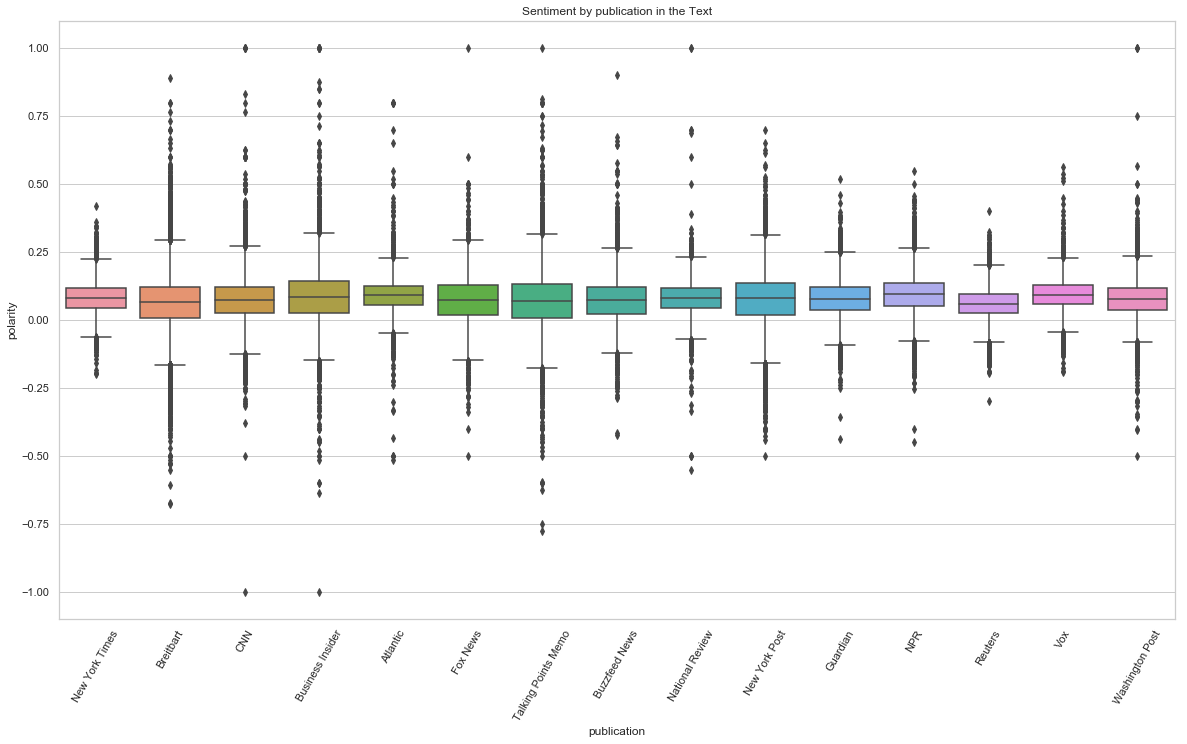

In [112]:
plt.figure(figsize=(20,11))
ax = sns.boxplot(x="publication", y="polarity", data=df3)
# ax = sns.swarmplot(x="category", y="polarity", data=df_news, color=".25")
ax.set_title('Sentiment by publication in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

## Graficos de Sentimientos Subjetividad

Al observar el boxplot se interpreta que la media de subjetividad se encuentra aproximadamente en 0.4, es decir, las noticias tienen argumentos de tendencia objetiva

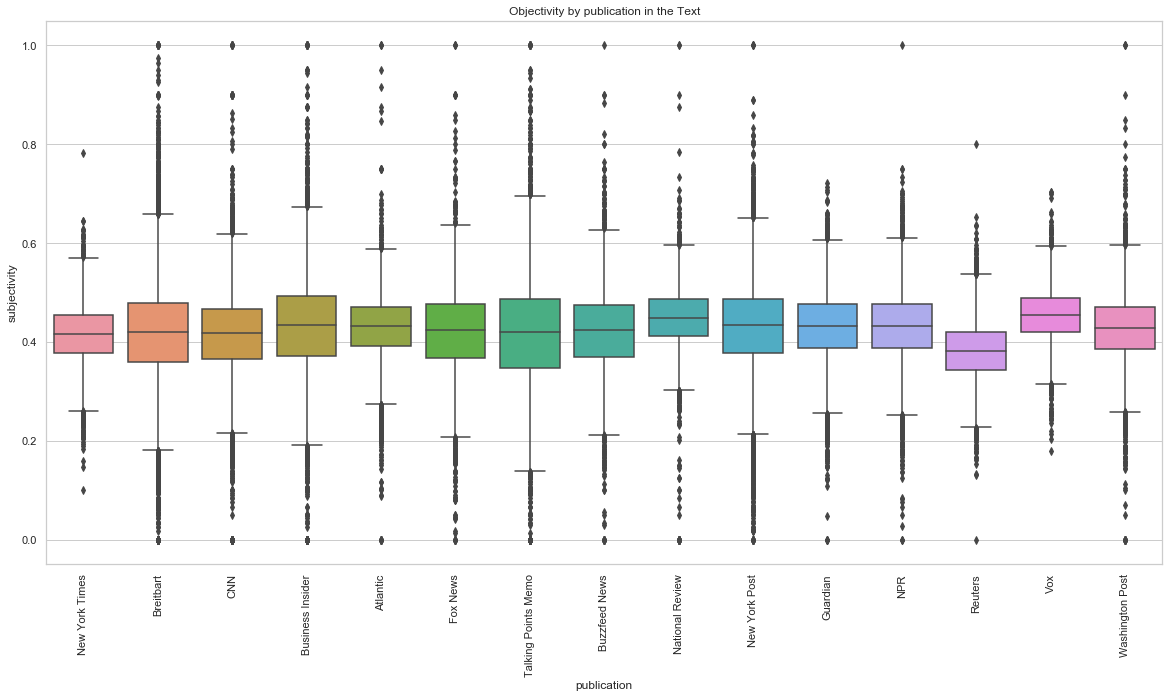

In [113]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="publication", y="subjectivity", data=df3)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Objectivity by publication in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

News by year

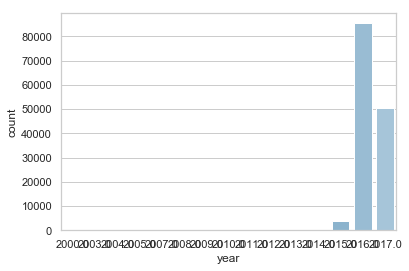

In [115]:
plt.figure(figsize=(30,50))
ax.set_title('Number of news by Year')
ax = sns.countplot(x="year", data=df3, palette="Blues_d")

In [118]:
df3['qty']= 1
df_cat_year = df3.groupby(['publication', 'year']).agg({'polarity': 'mean', 
                                     'subjectivity': 'mean', 
                                     'qty':'count'})
df_cat_year.head(20)

polarity  subjectivity    qty
publication      year                                 
Atlantic         2016.0  0.092408      0.429409   5150
                 2017.0  0.087928      0.427240   2029
Breitbart        2013.0  0.066993      0.464237      2
                 2014.0  0.049313      0.333850      1
                 2015.0  0.069699      0.434351     72
                 2016.0  0.067129      0.423524  16100
                 2017.0  0.059448      0.411060   7606
Business Insider 2016.0  0.093714      0.436352   4596
                 2017.0  0.079801      0.419106   2161
Buzzfeed News    2016.0  0.070648      0.420590   3254
                 2017.0  0.081391      0.425630   1600
CNN              2011.0 -0.011742      0.529545      1
                 2012.0  0.093793      0.407035     26
                 2013.0  0.078905      0.349754    210
                 2014.0  0.114896      0.393093     74
                 2015.0  0.082262      0.419316   3251
                 2016.0  0.076478      0.420328   4104
                 2017.0  0.071746      0.407139   3822
Fox News         2004.0  0.122059      0.507598      1
                 2011.0  0.037781      0.374753      1

In [119]:
df_cat_year.reset_index(inplace=True)

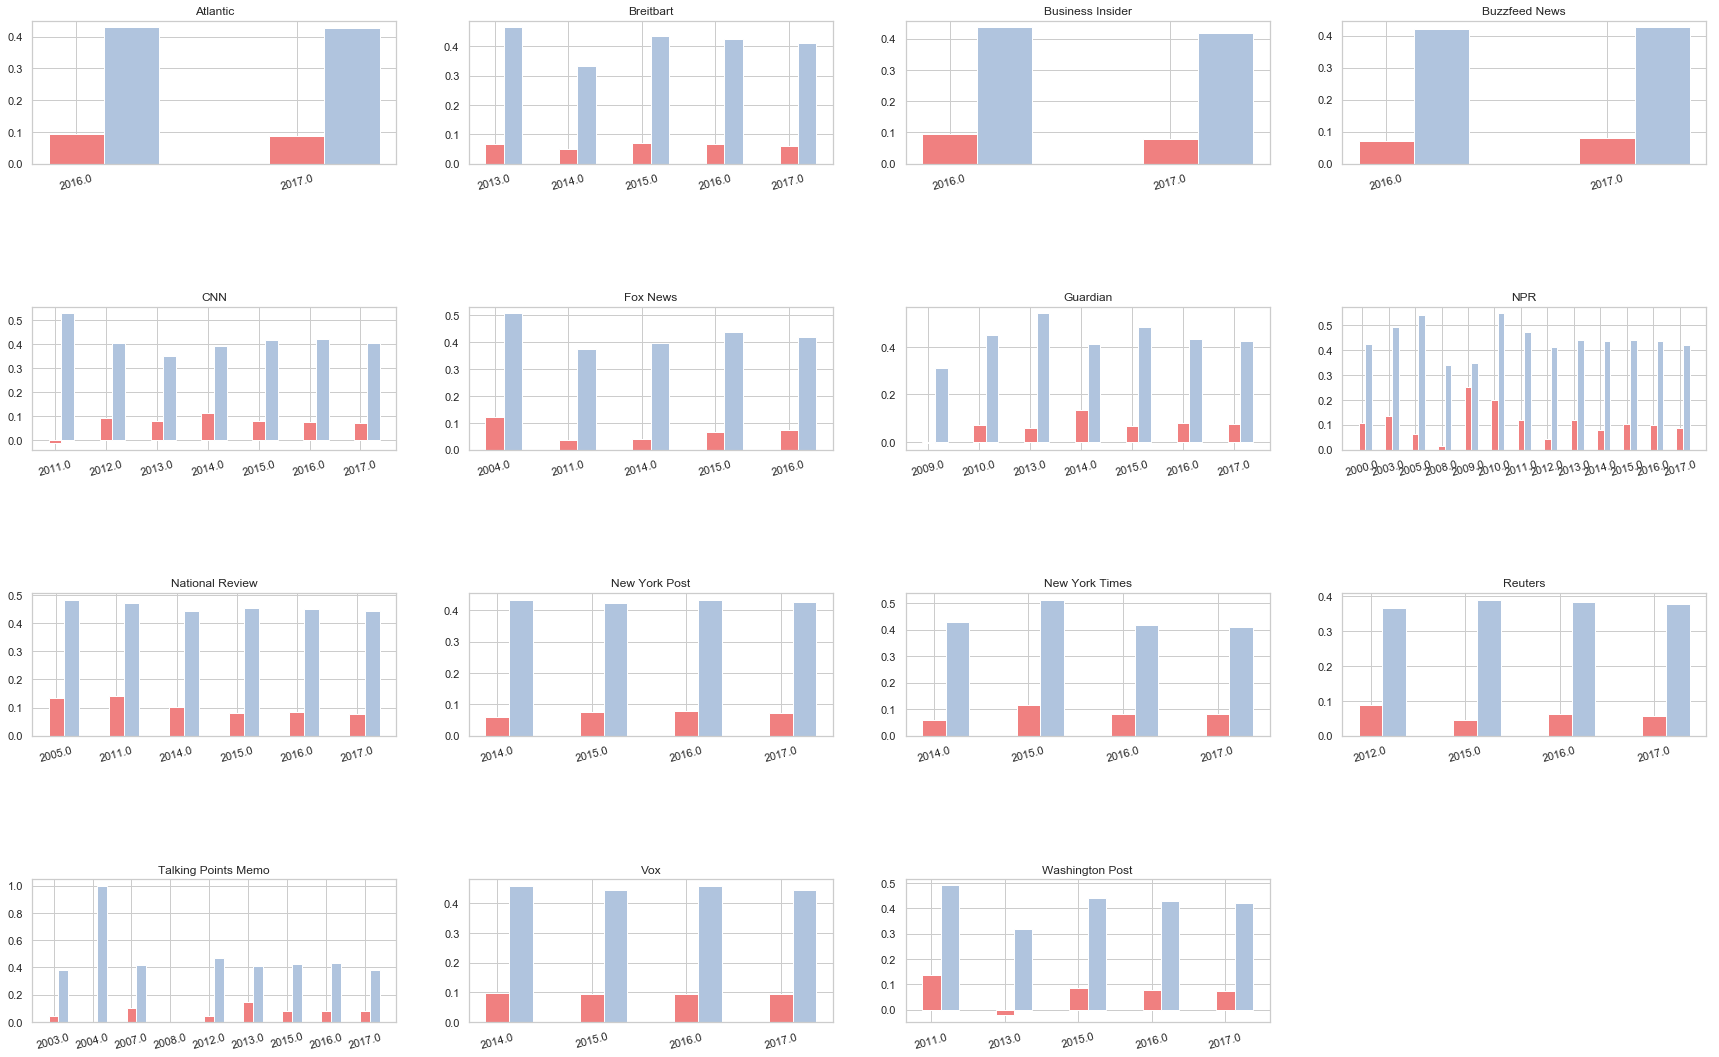

In [122]:
fig1 = plt.figure(figsize=(30,50))
fig1.subplots_adjust(hspace = 1)
chrt = 0
for i, group in df_cat_year.groupby('publication'):
    chrt += 1
    barWidth = 0.25
    ax = fig1.add_subplot(10,4, chrt)
    x = group.year
    bars1 = group.polarity
    bars2 = group.subjectivity
    r1 = np.arange(len(x))
    r2 = [x + barWidth for x in r1]

    ax.bar(r1, bars1, color='#F08080', width=barWidth, edgecolor='white', label='Polarity')
    ax.bar(r2, bars2, color='#B0C4DE', width=barWidth, edgecolor='white', label='Subjectivity')
    ax.set_title(str(i))
    ax.set_xticks(range(len(bars1)))
    ax.set_xticklabels([str(x1) for x1 in x], rotation=15)

In [131]:
df_publication = df3.groupby(['publication']).agg({'polarity': 'mean', 
                                     'subjectivity': 'mean', 
                                     'qty':'count'}).reset_index()
df_publication.head()

,publication,polarity,subjectivity,qty
0,Atlantic,0.091142,0.428796,7179
1,Breitbart,0.064679,0.419570,23781
2,Business Insider,0.089265,0.430836,6757
3,Buzzfeed News,0.074189,0.422251,4854
4,CNN,0.076864,0.414168,11488


In [132]:
df_publication.drop([0], axis=0, inplace =True)
df_publication.reset_index(drop=True, inplace=True)
df_publication.head()

,publication,polarity,subjectivity,qty
0,Breitbart,0.064679,0.419570,23781
1,Business Insider,0.089265,0.430836,6757
2,Buzzfeed News,0.074189,0.422251,4854
3,CNN,0.076864,0.414168,11488
4,Fox News,0.073747,0.419665,4354


## Top Publication

In [133]:
df_publication.sort_values(['qty'], ascending=False).head(10)

,publication,polarity,subjectivity,qty
0,Breitbart,0.064679,0.419570,23781
8,New York Post,0.076400,0.429713,17493
6,NPR,0.093988,0.430609,11992
3,CNN,0.076864,0.414168,11488
13,Washington Post,0.077459,0.426643,11114
10,Reuters,0.059684,0.381769,10710
5,Guardian,0.078513,0.429406,8681
9,New York Times,0.081993,0.415095,7803
1,Business Insider,0.089265,0.430836,6757
7,National Review,0.081486,0.447650,6203


In [137]:
def plot_grouped_bar(dataframe, title):
  barWidth = 0.25

  # set height of bar
  bars1 = dataframe.polarity
  bars2 = dataframe.subjectivity

  # Set position of bar on X axis
  r1 = np.arange(len(bars1))
  r2 = [x + barWidth for x in r1]

  # Make the plot
  plt.figure(figsize=(15,10))
  plt.bar(r1, bars1, color='#F08080', width=barWidth, edgecolor='white', label='Polarity')
  plt.bar(r2, bars2, color='#B0C4DE', width=barWidth, edgecolor='white', label='Subjectivity')

  # Add xticks on the middle of the group bars
  plt.title(title)
  plt.xlabel('group', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(bars1))], df.publication)
  plt.xticks(rotation=60)
  plt.legend()
  plt.show()

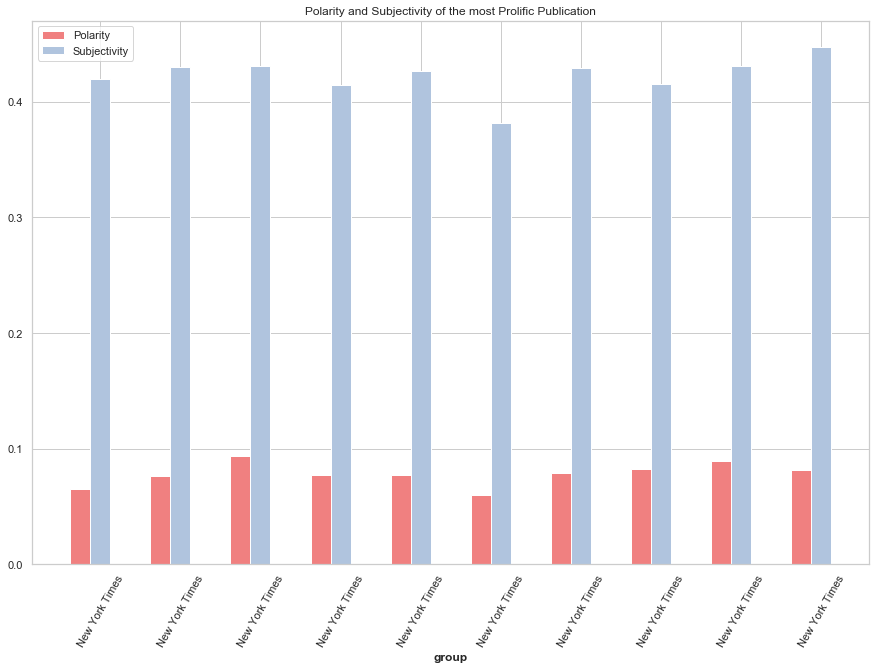

In [138]:
plot_grouped_bar(df_publication.sort_values(['qty'], ascending=False).head(10), "Polarity and Subjectivity of the most Prolific Publication")

By means the Publication with the most articles have written around 10000 articles along the years, with a hight subjectivity an neutral polarity.

In [144]:
df_publication[df_publication.qty >10000].sort_values(['polarity'], ascending=False).head(10)

,publication,polarity,subjectivity,qty
6,NPR,0.093988,0.430609,11992
13,Washington Post,0.077459,0.426643,11114
3,CNN,0.076864,0.414168,11488
8,New York Post,0.076400,0.429713,17493
0,Breitbart,0.064679,0.419570,23781
10,Reuters,0.059684,0.381769,10710


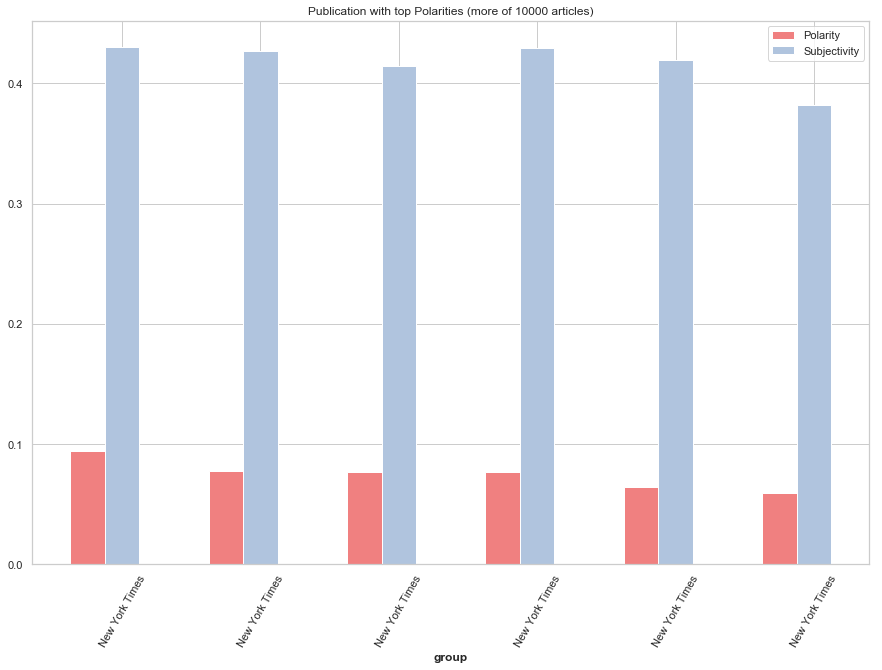

In [146]:
plot_grouped_bar(df_publication[df_publication.qty >10000].sort_values(['polarity'], ascending=False).head(10), "Publication with top Polarities (more of 10000 articles)")

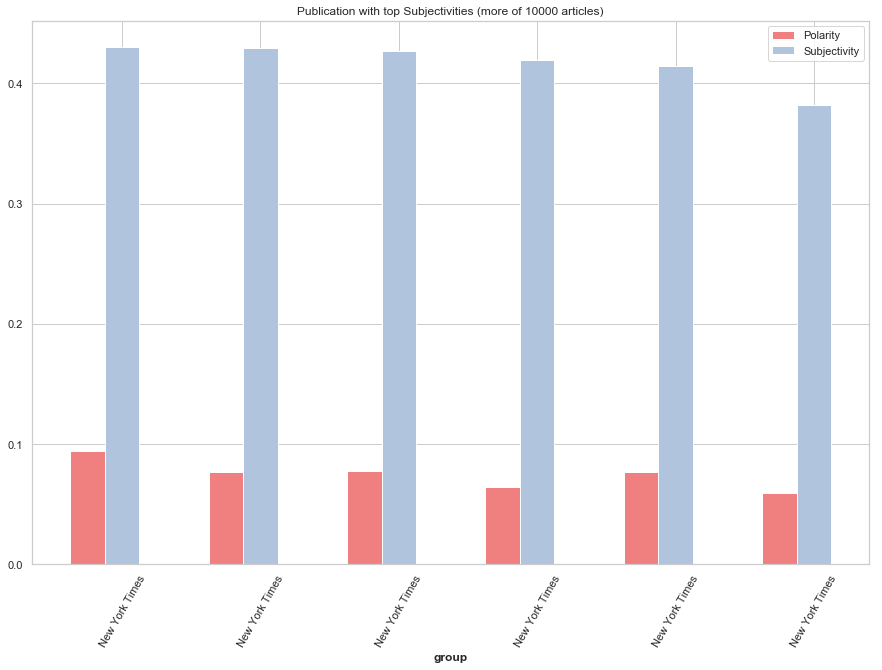

In [147]:
plot_grouped_bar(df_publication[df_publication.qty >10000].sort_values(['subjectivity'], ascending=False).head(10), "Publication with top Subjectivities (more of 10000 articles)")